# Using XGBoost to predict sales
## Data from BigQuery's The Look dataset

### Import relevant packages

In [36]:
# Import packages

# Determining working paths
import os

# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Handling dates
import datetime as dt

# Modelling
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##### I like to make sure we are working in the right environment

In [37]:
# Ensure correct working path
print(f"Working path is {os.getcwd()}")

Working path is c:\Users\akbar\OneDrive\Desktop\Projects\2024


### Import data
#### We are skipping rigorous EDA for now, but focusing on building an ML model

In [38]:
# Import data
df = pd.read_csv("bigquery_thelook_beforeJun2024.csv")

# Inspect data
df.head(5)

,created_at_date,number_of_orders
0,1/1/2020,9
1,2/1/2020,13
2,3/1/2020,14
3,4/1/2020,18
4,5/1/2020,13


In [39]:
# Determining data types
print(f"Data types are: \n{df.dtypes}")

Data types are: 
created_at_date     object
number_of_orders     int64
dtype: object


### Prepare user-defined functions

#### Let's transform the data by converting the date field to a date type

In [52]:
# Transform data
def transformData(df):
    df = df.copy()
    # Convert date field to datetime type
    df["date"] = pd.to_datetime(df["created_at_date"], format = '%d/%m/%Y')
    df["orders"] = df["number_of_orders"]
    df = df[["date", "orders"]]
    df = df.set_index("date")
    return df

#### Some feature-engineering where we derive more information from the date field

In [53]:
# Create features
def createFeatures(df):
    df = df.copy()
    df["day"] = df.index.day
    df["day_of_week"] = df.index.dayofweek
    df["week"] = df.index.isocalendar().week
    df["month"] = df.index.month
    #df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    return df

#### Prior to training a model, let's split our data into train and test sets based on a cut-off date

In [54]:
# Split data into train and test sets
def splitData(df, days_before = 14):
    df = df.copy()
    cutoff_date = max(df.index) - dt.timedelta(days = days_before)
    train = df.loc[df.index <= cutoff_date]
    test = df.loc[df.index > cutoff_date]
    return train, test

#### Let's create an XGBoost regression model and fit it, i.e. train it

In [55]:
# Initialise and fit model
def createModel(train, test):
    train = train.copy()
    test = test.copy()
    features = list(train.columns)[1:]
    target = 'orders'
    XTrain = train[features]
    YTrain = train[target]
    XTest = test[features]
    YTest = test[target]
    reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
    reg.fit(XTrain, YTrain, eval_set = [(XTrain, YTrain), (XTest, YTest)], verbose = 100)
    return XTrain, YTrain, XTest, YTest, reg, features, target

#### Understanding which features were important to the model to generate the predictions

In [57]:
# Identify important features
def featuresImportance(reg):
    df = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns = ['importance'])
    fig, ax = plt.subplots(figsize = (15, 5))
    df.plot(kind = 'barh', ax = ax, y = 'importance')
    ax.set_title('Feature Importance')
    plt.show()
    return df

#### Run the trained model against the test set to see if it performs well - to determine if there's under- or over-fitting

In [73]:
# Perform prediction
def getPrediction(reg, XTest, test, dfFeatures):
    test = test.copy()
    dfFeatures = dfFeatures.copy()
    test['prediction'] = reg.predict(XTest)
    dfMerge = dfFeatures.merge(test['prediction'], how = 'left', left_index = True, right_index = True)
    fig, ax = plt.subplots(figsize = (15, 5))
    dfMerge["orders"].plot(ax = ax)
    dfMerge['prediction'].plot(ax = ax, style = '.')
    plt.legend(['Actual', 'Prediction'])
    ax.set_title('Actual vs Prediction')
    plt.show()
    rmse = np.sqrt(mean_squared_error(test['orders'], test['prediction']))
    print(f"RMSE of model for test set is {rmse}")
    return dfMerge

#### Prepare a dataframe containing future time periods, i.e. 14 days into the future, considered to be unseen data as well as run the model against these future time periods

In [66]:
# Create forecast dataframe
def createForecast(latest_date, features, target, reg, days_after = 14):
    forecastDateList = []
    for i in range(days_after):
        forecastDate = latest_date + dt.timedelta(days = i+1)
        forecastDateList.append(forecastDate)
    forecastDf = pd.DataFrame(forecastDateList)
    forecastDf = forecastDf.rename(columns = {0:'date'})
    forecastDf['orders'] = 0
    forecastDf = forecastDf.set_index('date')
    forecastDf['orders'] = 0
    # Get features
    forecastDf = createFeatures(forecastDf)
    forecastDf['orders'] = reg.predict(forecastDf[features])
    forecastDf['type'] = 'forecast'
    return forecastDf

#### Combine actual data and forecast data (i.e. a dataframe with both past data and future data)

In [67]:
# Combine forecast with actual data
def getOutlook(dfFeatures, forecastDf):
    dfFeatures = dfFeatures.copy()
    dfFeatures['type'] = 'actual'
    # Concat actual and forecast
    dfConcat = pd.concat([dfFeatures, forecastDf])
    return dfConcat

#### String these functions into a neat pipeline

In [74]:
def pipeline(filename = 'bigquery_thelook_beforeJun2024.csv', startDate = '2023-01-01'):
    df = pd.read_csv(filename)
    dfTransformed = transformData(df)
    dfTransformed = dfTransformed.loc[dfTransformed.index >= startDate]
    dfFeatures = createFeatures(dfTransformed)
    train, test = splitData(dfFeatures)
    XTrain, YTrain, XTest, YTest, reg, features, target = createModel(train, test)
    dfFeaturesImportance = featuresImportance(reg)
    dfMerge = getPrediction(reg, XTest, test, dfFeatures)
    # Train model across entire dataset
    forecastDf = createForecast(latest_date = max(dfFeatures.index), features = features, target = target, reg = reg)
    #print(forecastDf)
    dfConcat = getOutlook(dfFeatures, forecastDf)
    fig, ax = plt.subplots(figsize = (15, 5))
    sns.lineplot(data = dfConcat, x = dfConcat.index, y = 'orders', hue = 'type')
    plt.ylim(0)
    ax.set_title("Forecasting the next 14 days")
    plt.show()
    return forecastDf, dfConcat, train, test
    

#### Let's run the pipeline for some forecasting action!

[0]	validation_0-rmse:44.30559	validation_1-rmse:150.97277


[100]	validation_0-rmse:19.57873	validation_1-rmse:82.74504
[200]	validation_0-rmse:11.31255	validation_1-rmse:54.92235
[300]	validation_0-rmse:8.40222	validation_1-rmse:44.35894
[400]	validation_0-rmse:7.25264	validation_1-rmse:36.46042
[500]	validation_0-rmse:6.62227	validation_1-rmse:30.53193
[600]	validation_0-rmse:6.10706	validation_1-rmse:27.23708
[700]	validation_0-rmse:5.64241	validation_1-rmse:26.16153
[800]	validation_0-rmse:5.30801	validation_1-rmse:25.97109
[839]	validation_0-rmse:5.18812	validation_1-rmse:26.00855


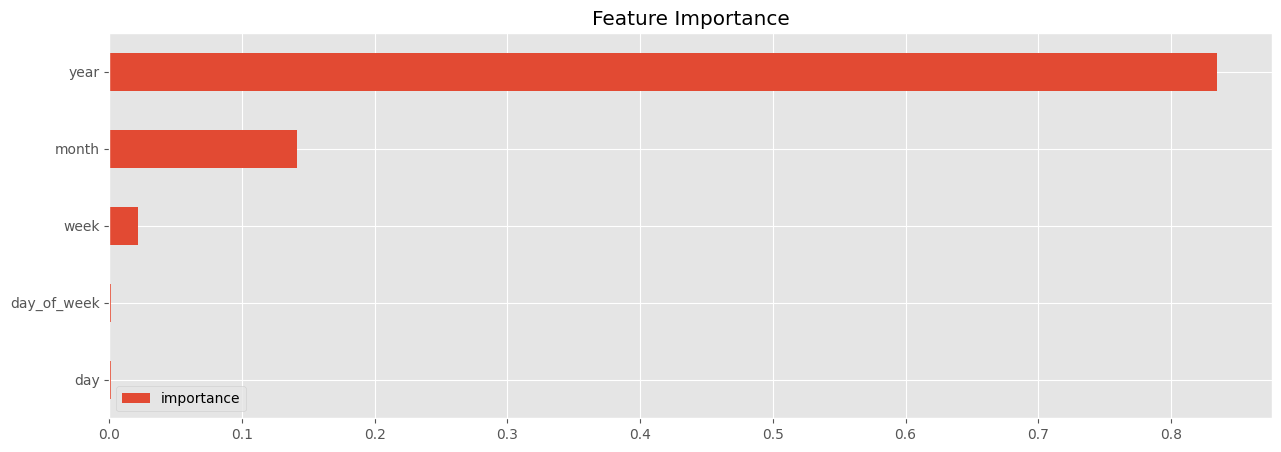

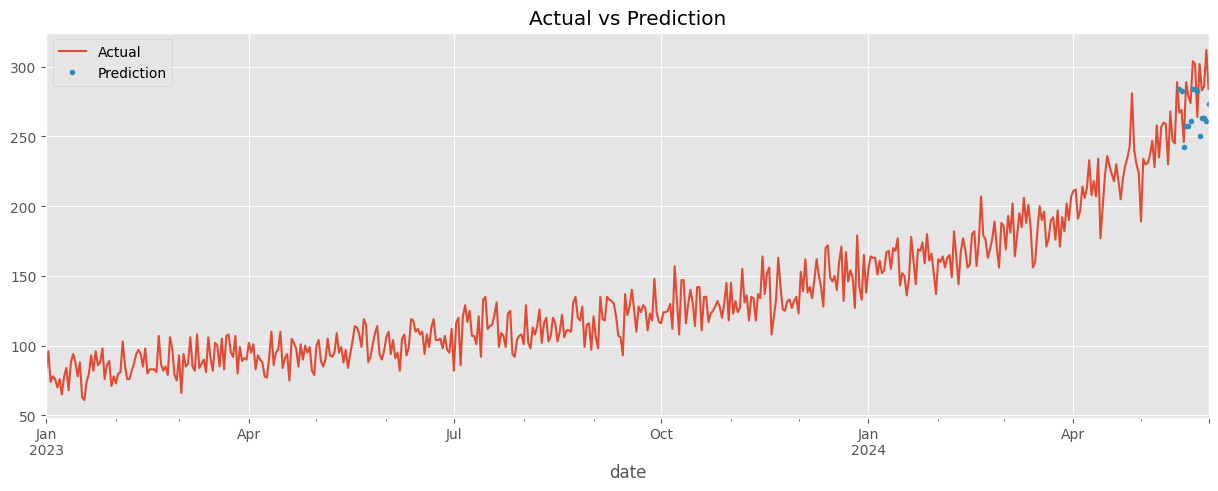

RMSE of model for test set is 25.962062518711054


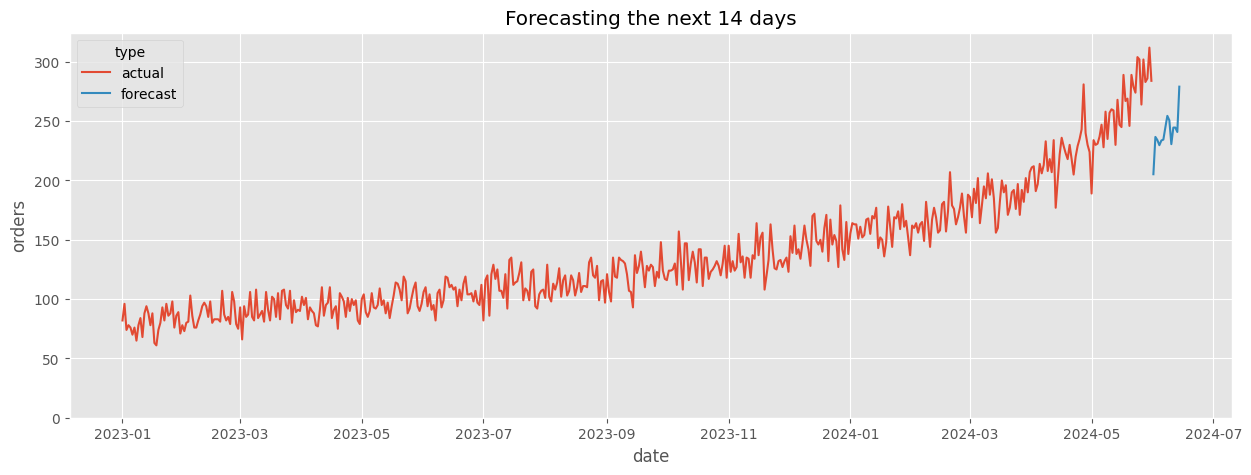

In [75]:
forecastDf, dfConcat, train, test = pipeline()